In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [44]:
scaler = StandardScaler()
pca = PCA()

In [45]:
full_df = pd.read_csv('../Data/career_pivot_results.csv')
print('Full Data Frame')
print(full_df.head())

Full Data Frame
  O*NET-SOC Code                                Title  A: Arm-Hand Steadiness  \
0     11-1011.00                     Chief Executives                    0.50   
1     11-1011.03        Chief Sustainability Officers                    0.00   
2     11-1021.00      General and Operations Managers                    0.88   
3     11-2011.00  Advertising and Promotions Managers                    0.50   
4     11-2021.00                   Marketing Managers                    0.12   

   A: Auditory Attention  A: Category Flexibility  A: Control Precision  \
0                   2.00                     4.00                  0.75   
1                   1.75                     3.50                  0.50   
2                   2.00                     3.25                  0.12   
3                   1.25                     3.88                  0.12   
4                   1.62                     3.62                  0.00   

   A: Deductive Reasoning  A: Depth Perception

In [46]:
# Keep only numeric columns for ML (exclude O*NET-SOC Code and Title)
numeric_df = full_df.select_dtypes(include=[np.number])
X = numeric_df.values

print(f"Shape: {X.shape}")
print(f"Numeric columns: {numeric_df.columns.tolist()[:5]}...")  # Show first 5

Shape: (894, 87)
Numeric columns: ['A: Arm-Hand Steadiness', 'A: Auditory Attention', 'A: Category Flexibility', 'A: Control Precision', 'A: Deductive Reasoning']...


In [47]:
X_scaled = scaler.fit_transform(X)

print("Original First Value:", X[0][0]) 

# The scaled data (Z-score, usually between -2 and +2)
print("Scaled First Value:", X_scaled[0][0])

# Verify Mean is ~0 and Std is ~1
print("New Mean:", X_scaled.mean().round(2))
print("New Std:", X_scaled.std().round(2))


Original First Value: 0.5
Scaled First Value: -1.4187069226581608
New Mean: 0.0
New Std: 1.0


Variance explained by PC1: 47.49%
Variance explained by PC2: 18.95%
Variance explained by PC3: 6.16%
Total variance with 2 components: 66.44%
Total variance with 3 components: 72.60%


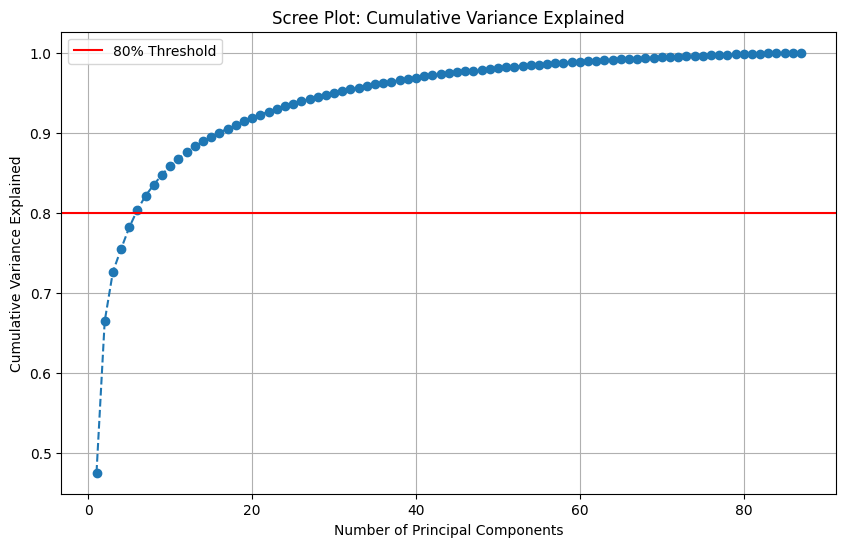

In [48]:
pca.fit(X_scaled)

evr = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(evr)

print(f"Variance explained by PC1: {evr[0]:.2%}")
print(f"Variance explained by PC2: {evr[1]:.2%}")
print(f"Variance explained by PC3: {evr[2]:.2%}")
print(f"Total variance with 2 components: {cumulative_variance[1]:.2%}")
print(f"Total variance with 3 components: {cumulative_variance[2]:.2%}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(evr) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Threshold')  # Threshold line
plt.title('Scree Plot: Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

In [50]:
feature_names = numeric_df.columns

loadings = pd.DataFrame(
    pca.components_, 
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

def interpret_component(pc_name):
    print(f"*** {pc_name} Interpretation ***")
    
    # Sort values to find the strongest POSITIVE contributors
    top_pos = loadings.loc[pc_name].nlargest(5)
    print("Top Positive (High Values):")
    print(top_pos)
    print("-" * 20)
    
    # Sort values to find the strongest NEGATIVE contributors
    top_neg = loadings.loc[pc_name].nsmallest(5)
    print("Top Negative (Low Values):")
    print(top_neg)
    print("\n")

interpret_component('PC1')
interpret_component('PC2')
interpret_component('PC3')

*** PC1 Interpretation ***
Top Positive (High Values):
S: Reading Comprehension    0.143484
A: Written Expression       0.143380
S: Writing                  0.143126
S: Speaking                 0.142439
S: Active Listening         0.141503
Name: PC1, dtype: float64
--------------------
Top Negative (Low Values):
A: Extent Flexibility       -0.130770
A: Static Strength          -0.129577
A: Dynamic Strength         -0.128630
A: Multilimb Coordination   -0.127266
A: Trunk Strength           -0.124234
Name: PC1, dtype: float64


*** PC2 Interpretation ***
Top Positive (High Values):
A: Perceptual Speed            0.190247
A: Visualization               0.182574
A: Flexibility of Closure      0.175960
S: Operations Monitoring       0.175934
S: Quality Control Analysis    0.174934
Name: PC2, dtype: float64
--------------------
Top Negative (Low Values):
S: Service Orientation     -0.003289
A: Speech Clarity           0.008012
A: Speech Recognition       0.013124
S: Social Perceptiveness    

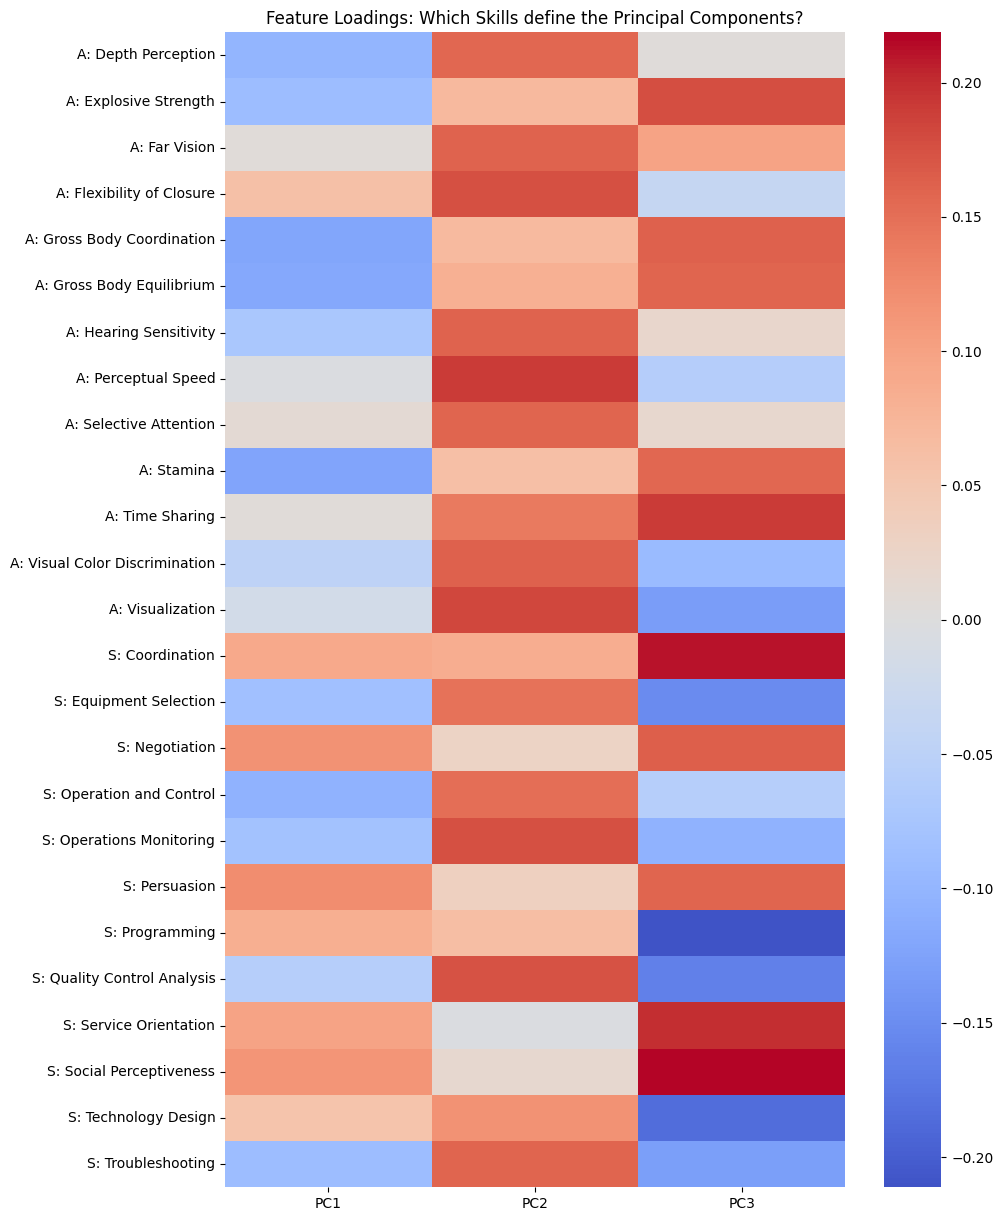

In [51]:
# Plot the top 3 Components and their relationship to a subset of skills
# We transpose (.T) so skills are on the side, PCs are on the bottom
plt.figure(figsize=(10, 15))

# We only pick the top 3 PCs to show in the chart
subset = loadings.iloc[:3].T 

# We filter to show only skills that have at least ONE strong connection (>0.15 or <-0.15)
# This removes "noise" skills that don't matter much
filtered_subset = subset[(subset.abs() > 0.15).any(axis=1)]

sns.heatmap(filtered_subset, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Loadings: Which Skills define the Principal Components?")
plt.show()

Visualizing the Data in 2D space

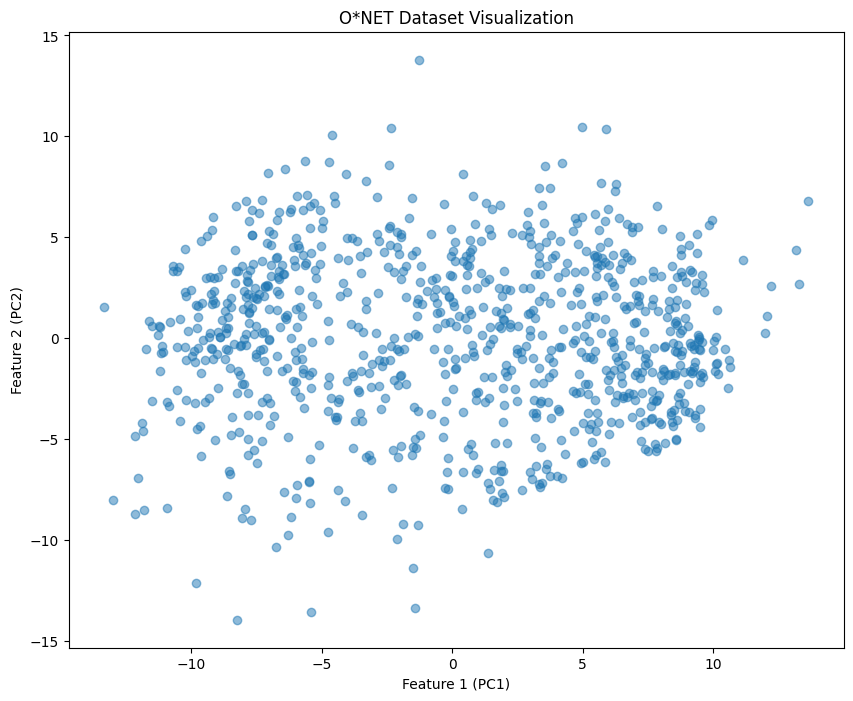

In [55]:
# 1. Create the 2 features (x1 and x2) from your real data
pca_simple = PCA(n_components=2)
coords = pca_simple.fit_transform(X_scaled)

x1 = coords[:, 0]  # This is your "Feature 1" (PC1)
x2 = coords[:, 1]  # This is your "Feature 2" (PC2)

# 2. Plot (Exactly your style)
plt.figure(figsize=(10, 8))
plt.scatter(x1, x2, marker='o', alpha=0.5) # alpha=0.5 makes it easier to see overlapping dots

plt.title('O*NET Dataset Visualization')
plt.xlabel('Feature 1 (PC1)')
plt.ylabel('Feature 2 (PC2)')
plt.show()

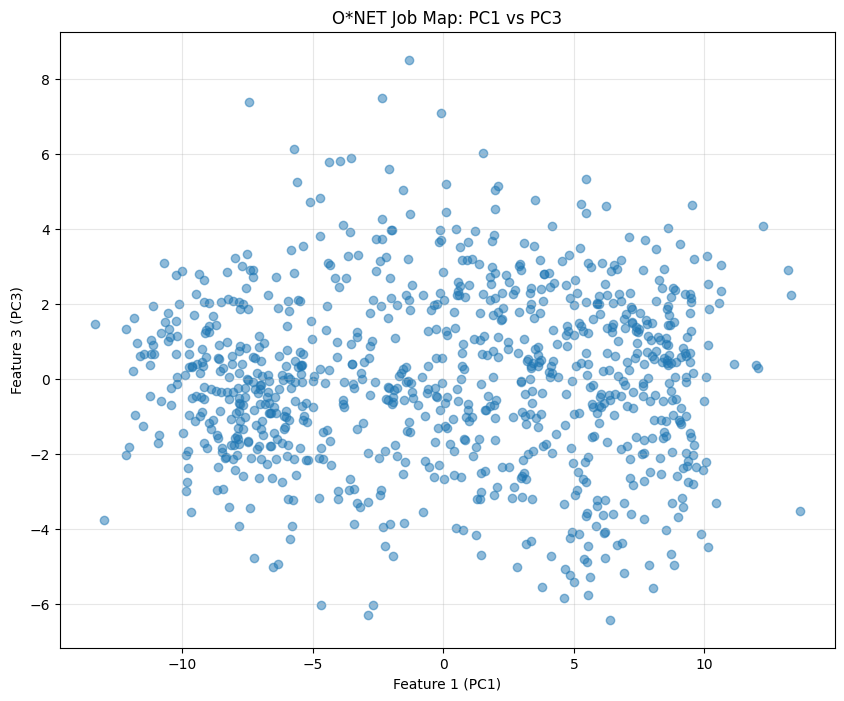

In [58]:
# 1. Create the features from your real data
# We need at least 3 components to access the 3rd one (index 2)
pca_simple = PCA(n_components=3)
coords = pca_simple.fit_transform(X_scaled)

x1 = coords[:, 0]  # This is PC1
x3 = coords[:, 2]  # This is PC3 (Index 2)

# 2. Plot PC1 vs PC3
plt.figure(figsize=(10, 8))
plt.scatter(x1, x3, marker='o', alpha=0.5) 

plt.title('O*NET Job Map: PC1 vs PC3')
plt.xlabel('Feature 1 (PC1)')
plt.ylabel('Feature 3 (PC3)')
plt.grid(True, alpha=0.3)
plt.show()